#Setting up environment

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
%%capture
!wget -v https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
%%capture
!tar -xvf spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
!pip install -q pyspark

     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 43.5 MB/s 


In [ ]:
# Setup Spark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [ ]:
# Imports

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from functools import reduce
from operator import add

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet

In [ ]:
# Create session
conf = SparkConf().set("spark.ui.port", "4050")

# Create context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

#Data Cleaning and Preparation

In [ ]:
stores = spark.read.csv('stores.csv', header = True)
stores.show(5)

+-----+----+------+
|Store|Type|  Size|
+-----+----+------+
|    1|   A|151315|
|    2|   A|202307|
|    3|   B| 37392|
|    4|   A|205863|
|    5|   B| 34875|
+-----+----+------+
only showing top 5 rows



In [ ]:
train_data = spark.read.csv('train.csv', header = True)
train_data.show(5)

+-----+----+----------+------------+---------+
|Store|Dept|      Date|Weekly_Sales|IsHoliday|
+-----+----+----------+------------+---------+
|    1|   1|2010-02-05|     24924.5|    FALSE|
|    1|   1|2010-02-12|    46039.49|     TRUE|
|    1|   1|2010-02-19|    41595.55|    FALSE|
|    1|   1|2010-02-26|    19403.54|    FALSE|
|    1|   1|2010-03-05|     21827.9|    FALSE|
+-----+----+----------+------------+---------+
only showing top 5 rows



In [ ]:
features = spark.read.csv('features.csv', header = True)
features.show(5)

+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|Store|      Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|    1|2010-02-05|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    FALSE|
|    1|2010-02-12|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|     TRUE|
|    1|2010-02-19|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|    FALSE|
|    1|2010-02-26|      46.63|     2.561|       NA|       NA|       NA|       NA|       NA|211.3196429|       8.106|    FALSE|
|    1|2010-03-05|       46.5|     2.625|       NA|       NA|       NA|       NA|       NA|211.3501429|       8

#Bucketing Stores

In [ ]:
stores = stores.withColumnRenamed("Store", "Store_s")

In [ ]:
from pyspark.sql.functions import when
stores.withColumn("Bucket", \
   when((stores.Size < 75000), lit("Small")) \
     .when((stores.Size >= 75000) & (stores.Size <= 150000), lit("Medium")) \
     .otherwise(lit("Large")) \
  ).show(5)

stores = stores.withColumn("Bucket", \
   when((stores.Size < 75000), lit("Small")) \
     .when((stores.Size >= 75000) & (stores.Size <= 150000), lit("Medium")) \
     .otherwise(lit("Large")) \
  )

+-------+----+------+------+
|Store_s|Type|  Size|Bucket|
+-------+----+------+------+
|      1|   A|151315| Large|
|      2|   A|202307| Large|
|      3|   B| 37392| Small|
|      4|   A|205863| Large|
|      5|   B| 34875| Small|
+-------+----+------+------+
only showing top 5 rows



In [ ]:
train_store_data = train_data.join(stores, train_data.Store ==  stores.Store_s, "inner")
cols=['Store_s']
train_store_data = train_store_data.drop(*cols)
train_store_data.show(5)

+-----+----+----------+------------+---------+----+------+------+
|Store|Dept|      Date|Weekly_Sales|IsHoliday|Type|  Size|Bucket|
+-----+----+----------+------------+---------+----+------+------+
|    1|   1|2010-02-05|     24924.5|    FALSE|   A|151315| Large|
|    1|   1|2010-02-12|    46039.49|     TRUE|   A|151315| Large|
|    1|   1|2010-02-19|    41595.55|    FALSE|   A|151315| Large|
|    1|   1|2010-02-26|    19403.54|    FALSE|   A|151315| Large|
|    1|   1|2010-03-05|     21827.9|    FALSE|   A|151315| Large|
+-----+----+----------+------------+---------+----+------+------+
only showing top 5 rows



In [ ]:
train_store_data = train_store_data.withColumn("Weekly_Sales", train_store_data.Weekly_Sales.cast('int'))

In [ ]:
small_stores_data = train_store_data.filter(train_store_data.Bucket == 'Small')
small_stores_data = small_stores_data.groupBy("Date").pivot("Store").sum("Weekly_Sales")
n = lit(len(small_stores_data.columns) - 1.0)
rowMean  = (reduce(add, (col(x) for x in small_stores_data.columns[1:])) / n).alias("mean")
small_stores_data = small_stores_data.withColumn("Mean", lit(rowMean))
small_stores_data.show(5)

+----------+------+------+------+------+------+------+------+------+------+------+------+------+-----------------+
|      Date|    16|     3|    30|    33|    36|    37|    38|    42|    43|    44|     5|     7|             Mean|
+----------+------+------+------+------+------+------+------+------+------+------+------+------+-----------------+
|2010-02-12|472018|420701|497353|294866|469545|529827|342190|575689|682901|286831|311803|524074|450649.8333333333|
|2010-09-24|511296|355598|448369|231958|419326|494243|330581|492242|650245|281292|293105|487979|416352.8333333333|
|2012-03-09|495921|445134|446595|287320|318654|535911|452767|659789|636657|303418|347267|579134|        459047.25|
|2010-08-20|521486|351698|447118|230501|437926|486909|329117|500922|712849|284719|287175|582319|431061.5833333333|
|2010-07-23|588312|352836|440469|252712|451999|491976|328317|491095|649014|292659|274717|570202|432025.6666666667|
+----------+------+------+------+------+------+------+------+------+------+-----

In [ ]:
medium_stores_data = train_store_data.filter(train_store_data.Bucket == 'Medium')
medium_stores_data = medium_stores_data.groupBy("Date").pivot("Store").sum("Weekly_Sales")
n = lit(len(medium_stores_data.columns) - 1.0)
rowMean  = (reduce(add, (col(x) for x in medium_stores_data.columns[1:])) / n).alias("mean")
medium_stores_data = medium_stores_data.withColumn("Mean", lit(rowMean))
medium_stores_data.show(5)

+----------+-------+-------+------+------+-------+------+-------+-------+------+------+-------+------+------+-----------------+
|      Date|     10|     12|    15|    17|     18|    21|     22|     23|    25|    29|     35|    45|     9|             Mean|
+----------+-------+-------+------+------+-------+------+-------+-------+------+------+-------+------+------+-----------------+
|2010-02-12|2175995|1117831|682415|841921|1187849|809289|1022543|1380858|583337|529647|1168790|656962|552644|977698.5384615385|
|2010-09-24|1655007| 851887|548509|852845| 950832|671656| 902745|1099025|607788|465309| 758042|678201|452878|807286.4615384615|
|2012-03-09|1917452|1113175|545087|860194|1084858|755054| 991092|1292692|643684|504718| 796323|776932|574925|912014.3076923077|
|2010-08-20|1983159| 948418|637060|783897|1141829|848843|1017015|1439871|724470|531608|1033688|708539|499299|945976.6153846154|
|2012-08-17|1827764|1004971|579706|844895|1048101|751931| 981239|1510097|728435|416851| 887947|722472|53

In [ ]:
large_stores_data = train_store_data.filter(train_store_data.Bucket == 'Large')
large_stores_data = large_stores_data.groupBy("Date").pivot("Store").sum("Weekly_Sales")
n = lit(len(large_stores_data.columns) - 1.0)
rowMean  = (reduce(add, (col(x) for x in large_stores_data.columns[1:])) / n).alias("mean")
large_stores_data = large_stores_data.withColumn("Mean", lit(rowMean))
large_stores_data.show(5)

+----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+------+-------+-------+------+----------+
|      Date|      1|     11|     13|     14|     19|      2|     20|     24|     26|     27|     28|     31|     32|    34|     39|      4|    40|     41|      6|     8|      Mean|
+----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+------+-------+-------+------+----------+
|2010-09-24|1351757|1170067|1705617|1879858|1318309|1724523|1789657|1169385| 868610|1596967|1111764|1230214|1067402|867508|1199417|1810650|844346|1110917|1275559|773694|1293311.05|
|2010-02-12|1641924|1574652|2030901|1704187|1536517|2137773|2109079|1414074|1015651|1745333|1558936|1543921|1123527|994578|1266197|2188276|955309|1075623|1606252|994774| 1510874.2|
|2012-03-09|1675400|1413349|1986413|2020805|1358784|1937590|2139230|1325798|1028534|1607309|168

In [ ]:
train_data = train_data.selectExpr("Store as Store_t", "Dept", "Date as Date_t", "Weekly_Sales", "IsHoliday as IsHoliday_t")

#Merging Data

In [ ]:
# Merging with Feature file
train_features_data = train_data.join(features,
               (train_data.Store_t == features.Store) & (train_data.Date_t == features.Date),
               "left")

# Dropping repeated cols
cols=['Store_t','Date_t','IsHoliday_t']
train_features_data = train_features_data.drop(*cols)

In [ ]:
# Merging with Stores file
merged_data = train_features_data.join(stores, train_features_data.Store == stores.Store_s, "left")

# Dropping common column
merged_data = merged_data.drop("Store_s")

In [ ]:
merged_data.show(5)

+----+------------+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+------+------+
|Dept|Weekly_Sales|Store|      Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|Type|  Size|Bucket|
+----+------------+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+------+------+
|   1|     24924.5|    1|2010-02-05|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    FALSE|   A|151315| Large|
|   1|    46039.49|    1|2010-02-12|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|     TRUE|   A|151315| Large|
|   1|    41595.55|    1|2010-02-19|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|    FALSE|   A|151315| Large|
|   1|    19403.

In [ ]:
# Casting columns 

merged_data.createOrReplaceTempView("CastDataToCorrectTypes")
merged_data = spark.sql(" SELECT INT(Store), INT(Dept), DATE(Date), \
DOUBLE(Weekly_Sales), BOOLEAN(IsHoliday), DOUBLE(Temperature), \
DOUBLE(Fuel_Price), DOUBLE(MarkDown1), DOUBLE(MarkDown2), \
DOUBLE(MarkDown3), DOUBLE(MarkDown4), DOUBLE(MarkDown5), \
DOUBLE(CPI), DOUBLE(Unemployment), STRING(TYPE),DOUBLE(SIZE) \
FROM CastDataToCorrectTypes")

In [ ]:
# Replace NA with 0 

merged_data=merged_data.na.fill(value=0)
merged_data.show(5)

+-----+----+----------+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+----+--------+
|Store|Dept|      Date|Weekly_Sales|IsHoliday|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|TYPE|    SIZE|
+-----+----+----------+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+----+--------+
|    1|   1|2010-02-05|     24924.5|    false|      42.31|     2.572|      0.0|      0.0|      0.0|      0.0|      0.0|211.0963582|       8.106|   A|151315.0|
|    1|   1|2010-02-12|    46039.49|     true|      38.51|     2.548|      0.0|      0.0|      0.0|      0.0|      0.0|211.2421698|       8.106|   A|151315.0|
|    1|   1|2010-02-19|    41595.55|    false|      39.93|     2.514|      0.0|      0.0|      0.0|      0.0|      0.0|211.2891429|       8.106|   A|151315.0|
|    1|   1|2010-02-26|    19403.54|    false|

In [ ]:
small_stores_data.createOrReplaceTempView("small")
medium_stores_data.createOrReplaceTempView("medium")
large_stores_data.createOrReplaceTempView("large")

all_stores_data = spark.sql('select small.Date as Week, small.Mean as Small, medium.Mean as Medium, large.Mean as Large \
from small join medium \
on small.Date = medium.Date join large \
on medium.Date = large.Date \
order by Week')
all_stores_data.show(5)

+----------+-----------------+------------------+----------+
|      Week|            Small|            Medium|     Large|
+----------+-----------------+------------------+----------+
|2010-02-05|         443825.5|1001705.3076923077| 1570066.5|
|2010-02-12|450649.8333333333| 977698.5384615385| 1510874.2|
|2010-02-19|        433787.75| 987532.9230769231|1511614.45|
|2010-02-26|420963.4166666667| 895300.8461538461| 1363838.9|
|2010-03-05|439443.6666666667| 949891.8461538461|1462409.55|
+----------+-----------------+------------------+----------+
only showing top 5 rows



#Trend Analysis

In [ ]:
all_stores_data = all_stores_data.toPandas()
all_stores_data.set_index('Week', inplace=True)
all_stores_data.index = pd.to_datetime(all_stores_data.index)

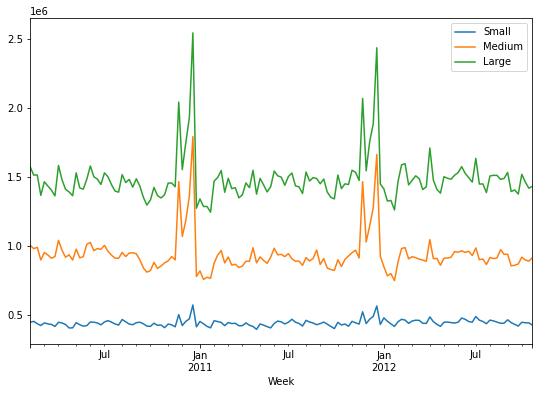

In [ ]:
#Plot sales trend for all stores
plt.rcParams['figure.figsize'] = (9, 6)
all_stores_data.plot()
plt.show()

In [ ]:
#Decompose time series (sales) for three stores types
small_stores_decomposed = seasonal_decompose(all_stores_data[['Small']], freq=52, model='multiplicative')
medium_stores_decomposed = seasonal_decompose(all_stores_data[['Medium']], freq=52, model='multiplicative')
large_stores_decomposed = seasonal_decompose(all_stores_data[['Large']], freq=52, model='multiplicative')

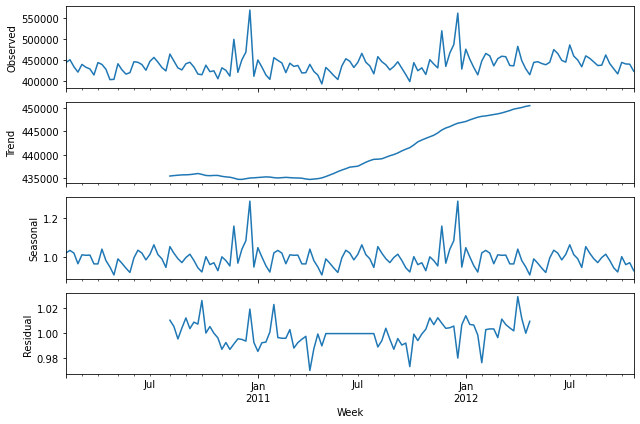

In [ ]:
#Plot decomposed time series (sales) for small stores 
small_stores_decomposed.plot()
plt.show()

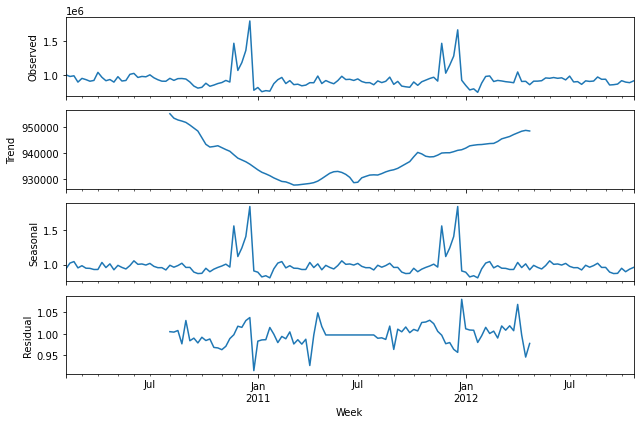

In [ ]:
#Plot decomposed time series (sales) for medium stores 
medium_stores_decomposed.plot()
plt.show()

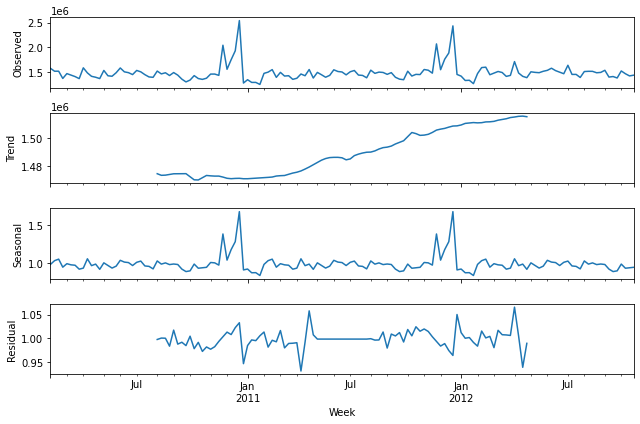

In [ ]:
#Plot decomposed time series (sales) for large stores 
large_stores_decomposed.plot()
plt.show()

## EDA

In [ ]:
N_stores=merged_data.select('Store').distinct().count()
print("Number of stores = ", N_stores)

Number of stores = 45


In [ ]:
N_Dept=merged_data.select('Dept').distinct().count()
print("Number of Department = ", N_Dept)

Number of Department = 81


In [ ]:
sales_plot=train_data.groupby('Date_t').agg(sum('Weekly_Sales').alias('Weekly_Sales')).sort(['Date_t'],ascending=[True])
sales_plot=sales_plot.toPandas()

In [ ]:
sales_plot.set_index('Date_t', inplace=True)
sales_plot.index = pd.to_datetime(sales_plot.index)

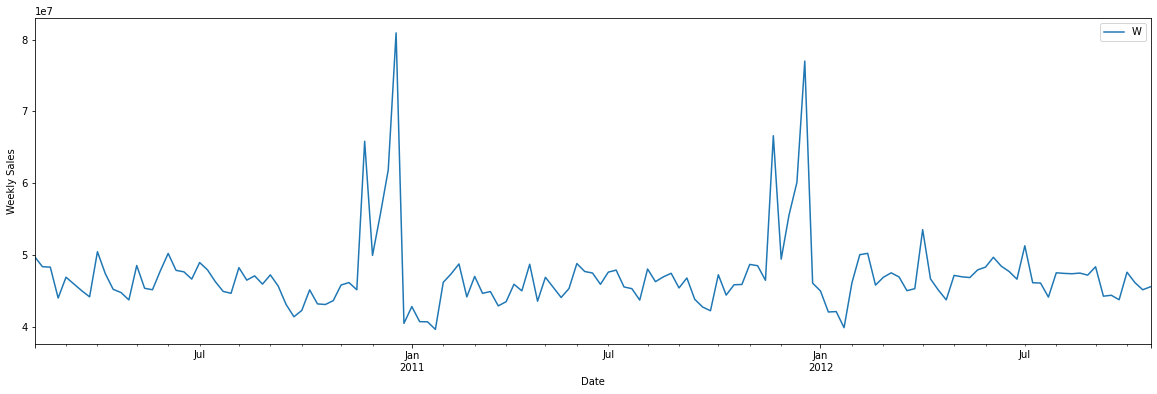

In [ ]:
plt.rcParams['figure.figsize'] = (20, 6)
sales_plot.plot()
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(('WeeklySales'))
plt.show()

In [ ]:
sales_plot_markdown=merged_data.groupby('Date').agg(sum('MarkDown1'),sum('MarkDown2'),sum('MarkDown3'),sum('MarkDown4'),sum('MarkDown5')).sort(['Date'],ascending=[True])
sales_plot_markdown=sales_plot_markdown.toPandas()

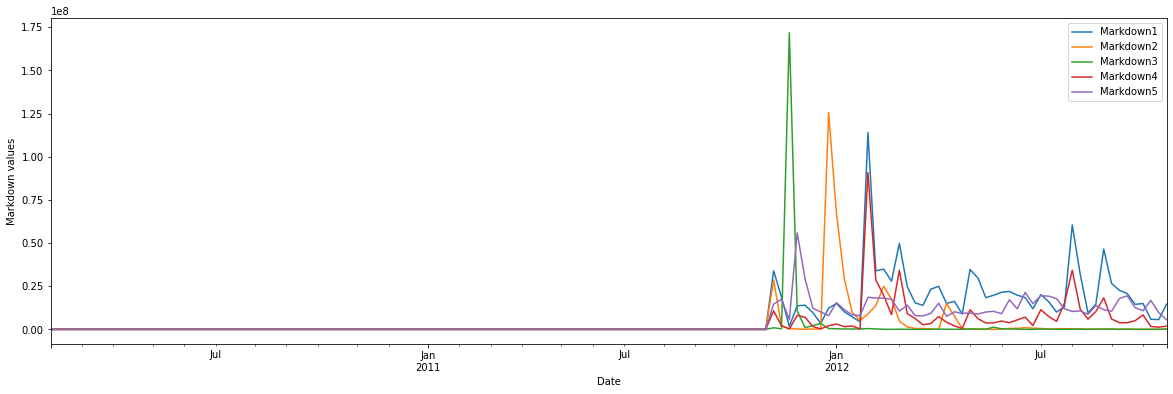

In [ ]:
sales_plot_markdown.set_index('Date', inplace=True)
sales_plot_markdown.index = pd.to_datetime(sales_plot_markdown.index)
plt.rcParams['figure.figsize'] = (20, 6)
sales_plot_markdown.plot()
plt.xlabel('Date')
plt.ylabel('Markdown values')
plt.legend(('Markdown1', 'Markdown2', 'Markdown3','Markdown4','Markdown5'))
plt.show()

Text(0.5, 1.0, 'Distribution of Stores')

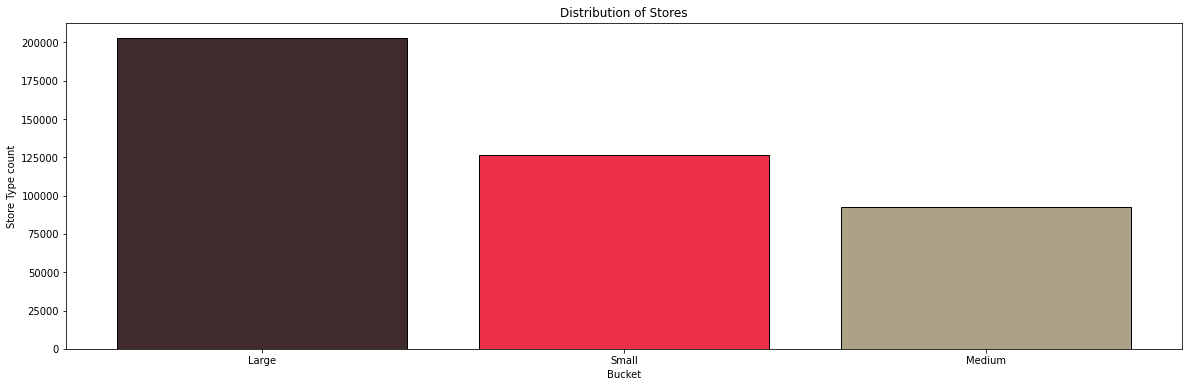

In [ ]:
pie_plot=train_store_data.toPandas()
stores = pie_plot['Bucket'].unique().tolist()
label=pie_plot['Bucket'].value_counts().tolist()
plt.bar(stores,label,color=['#3F2B2C','#EC3047','#ACA287'],edgecolor='black')
plt.xlabel("Bucket")
plt.ylabel("Store Type count")
plt.title("Distribution of Stores")  

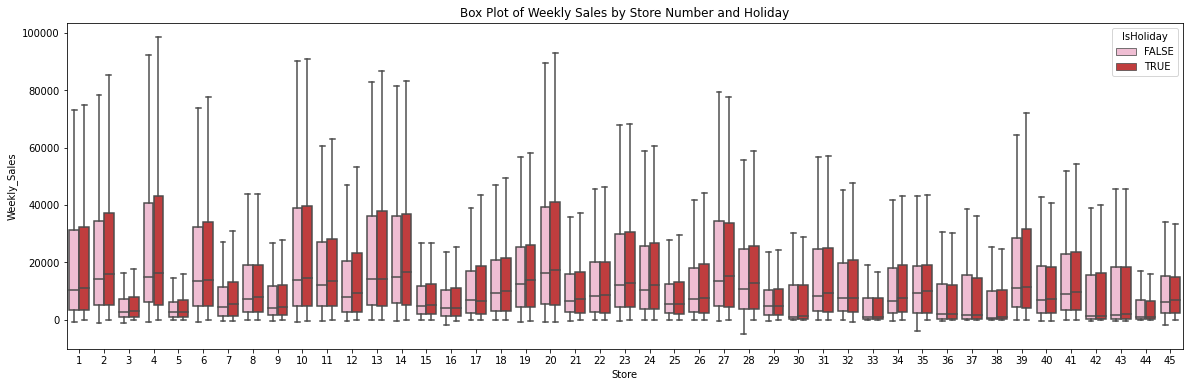

In [ ]:
data4 = train_store_data.select('Store','Weekly_Sales','IsHoliday').toPandas()
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Store Number and Holiday')
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=data4, showfliers=False, hue='IsHoliday',palette="tab20_r")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

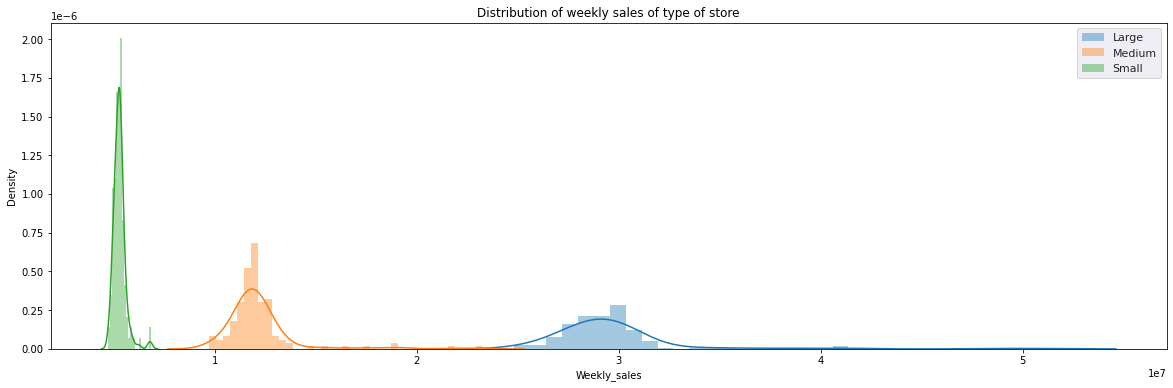

In [ ]:
raw=train_store_data.groupby(['Bucket','Date','IsHoliday']).agg(sum('Weekly_Sales').alias('Weekly_sales')).toPandas()
type_A=raw[raw['Bucket']=='Large']
type_B=raw[raw['Bucket']=='Medium']
type_C=raw[raw['Bucket']=='Small']
sns.distplot(type_A['Weekly_sales'],label='Large')
sns.distplot(type_B['Weekly_sales'],label='Medium')
sns.distplot(type_C['Weekly_sales'],label='Small')
sns.set(rc={'figure.figsize':(12.7,6.27)})
plt.legend()
plt.title('Distribution of weekly sales of type of store')
plt.show()

#Multi Time Series Forecasting

In [ ]:
# Set Holidays
holidays = pd.DataFrame({
    'holiday': ['Super_Bowl']*4 + ['Labor_Day']*4 + ['Thanksgiving']*4 + ['Christmas']*4,
    'ds': pd.to_datetime(['12-02-2010', '11-02-2011', '10-02-2012', '08-02-2013',
                          '10-09-2010', '09-09-2011', '07-09-2012', '06-09-2013',
                          '26-10-2010', '25-10-2011', '23-10-2012', '29-10-2013',
                          '31-12-2010', '30-12-2011', '28-12-2012', '27-12-2013',]),
    'lower_window': 0,
    'upper_window': 1,
})

In [ ]:
# Read the training file into a dataframe
train = (spark.read
              .format("csv")
              .option('header', True)
              .option('inferSchema', True)
              .load('/content/train.csv')
              .drop('IsHoliday')
              )
 
# Make the dataframe queriable as a temporary view
train.createOrReplaceTempView('train')

In [ ]:
train.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Weekly_Sales: double (nullable = true)



In [ ]:
train.show(5)

+-----+----+----------+------------+
|Store|Dept|      Date|Weekly_Sales|
+-----+----+----------+------------+
|    1|   1|2010-02-05|     24924.5|
|    1|   1|2010-02-12|    46039.49|
|    1|   1|2010-02-19|    41595.55|
|    1|   1|2010-02-26|    19403.54|
|    1|   1|2010-03-05|     21827.9|
+-----+----+----------+------------+
only showing top 5 rows



In [ ]:
train.explain()

== Physical Plan ==
FileScan csv [Store#16,Dept#17,Date#18,Weekly_Sales#19] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/train.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Store:int,Dept:int,Date:string,Weekly_Sales:double>




In [ ]:
# Group and Repartition data

sql_statement = '''
  SELECT
    Store as store,
    Dept as dept,
    CAST(Date as date) as ds,
    SUM(Weekly_Sales) as y
  FROM train
  GROUP BY store, dept, ds
  ORDER BY store, dept, ds
  '''
 
train = (
  spark
    .sql( sql_statement )
    .repartition(sc.defaultParallelism, ['store', 'dept'])
  ).cache()

In [ ]:
train.explain()

== Physical Plan ==
InMemoryTableScan [store#86, dept#87, ds#88, y#89]
   +- InMemoryRelation [store#86, dept#87, ds#88, y#89], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(store#51, dept#52, 2), REPARTITION_BY_NUM, [id=#75]
            +- *(3) Sort [store#51 ASC NULLS FIRST, dept#52 ASC NULLS FIRST, ds#53 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(store#51 ASC NULLS FIRST, dept#52 ASC NULLS FIRST, ds#53 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#71]
                  +- *(2) HashAggregate(keys=[store#16, dept#17, _groupingexpression#60], functions=[sum(Weekly_Sales#19)])
                     +- Exchange hashpartitioning(store#16, dept#17, _groupingexpression#60, 200), ENSURE_REQUIREMENTS, [id=#67]
                        +- *(1) HashAggregate(keys=[store#16, dept#17, _groupingexpression#60], functions=[partial_sum(Weekly_Sales#19)])
                           +- *(1) Project [Store#16, Dept#17, Weekly_Sale

In [ ]:
train.show(5)

+-----+----+----------+--------+
|store|dept|        ds|       y|
+-----+----+----------+--------+
|    1|   5|2010-02-05|32229.38|
|    1|   5|2010-02-12|29620.81|
|    1|   5|2010-02-19|26468.27|
|    1|   5|2010-02-26|24101.89|
|    1|   5|2010-03-05|23082.14|
+-----+----+----------+--------+
only showing top 5 rows



In [ ]:
# Define Result Schema
result_schema = StructType([
  StructField('ds',DateType()),
  StructField('store',IntegerType()),
  StructField('dept',IntegerType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

In [ ]:
forecast_model = None

In [ ]:
# Forecasting
def forecast_store_dept( history_pd: pd.DataFrame ) -> pd.DataFrame:

  model = Prophet(
    interval_width=0.95,
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    holidays = holidays
    )
  
  model.fit( history_pd )

  future_pd = model.make_future_dataframe(
    periods=39, 
    freq='w',
    include_history=True
    )
  
  forecast_pd = model.predict( future_pd )  
 
  forecasting_model = model

  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
  h_pd = history_pd[['ds','store','dept','y']].set_index('ds')

  results_pd = f_pd.join( h_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)
  
  results_pd['store'] = history_pd['store'].iloc[0]
  results_pd['dept'] = history_pd['dept'].iloc[0]

  return results_pd[ ['ds', 'store', 'dept', 'y', 'yhat', 'yhat_upper', 'yhat_lower'] ]  

In [ ]:
# Apply forecasting function on training data 
from pyspark.sql.functions import current_date
 
results = (
  train
    .groupBy('store', 'dept')
      .applyInPandas(forecast_store_dept, schema=result_schema)
    .withColumn('training_date', current_date() )
    )

results.createOrReplaceTempView('forecasts')

In [ ]:
results.coalesce(1) 

DataFrame[ds: date, store: int, dept: int, y: float, yhat: float, yhat_upper: float, yhat_lower: float, training_date: date]

In [ ]:
test_sql = '''
SELECT 
ds,
y
yhat,
yhat_upper,
yhat_lower
FROM forecasts
WHERE store = 10 AND dept = 1
'''

test_result = spark.sql(test_sql)

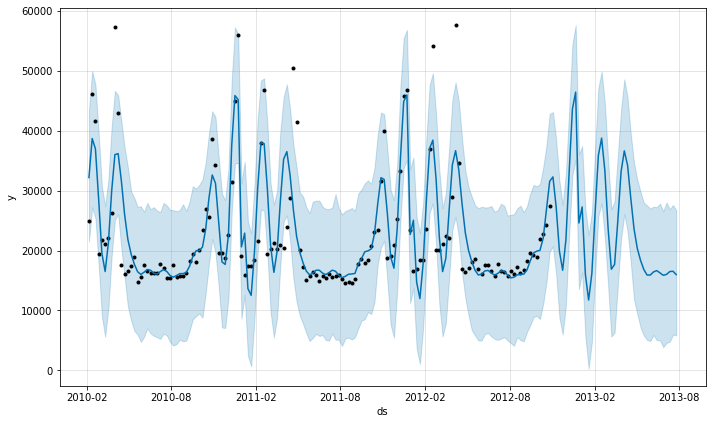

In [ ]:
forecast_fig = forecast_model.plot(test_result)

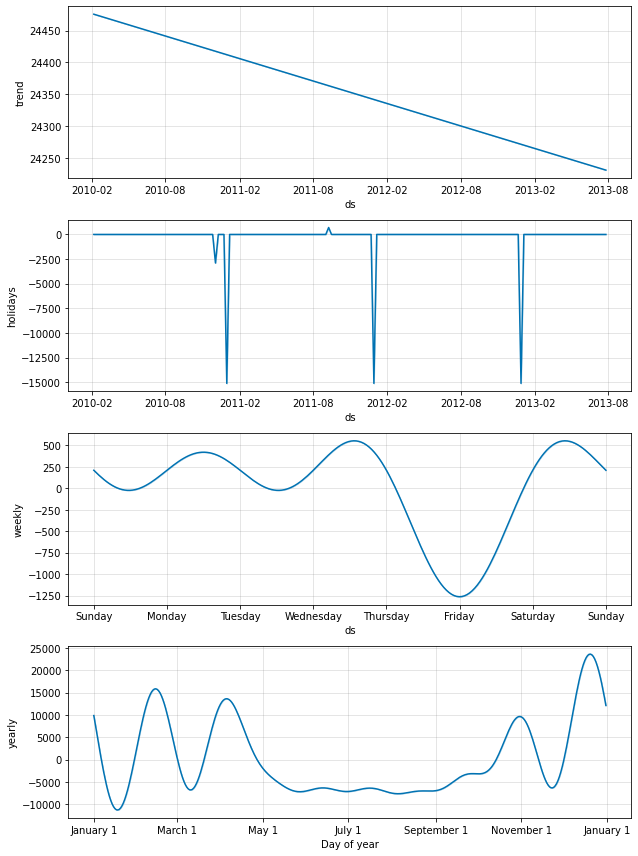

In [ ]:
trends_fig = forecast_model.plot_components(test_result)

In [ ]:
forecast_analysis = '''
SELECT 
ds,
y
yhat,
yhat_upper,
yhat_lower
FROM forecasts
WHERE store IN (1, 5, 10) AND dept = 1
'''

forecast_analysis_result = spark.sql(forecast_analysis).toPandas()

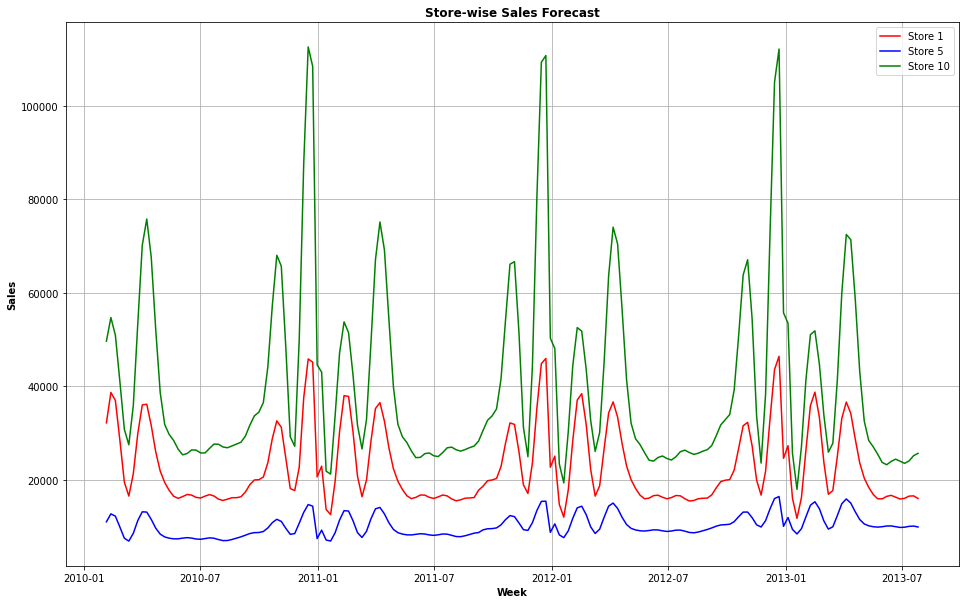

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlabel('Week', fontweight='bold')
ax.set_ylabel('Sales', fontweight='bold')

ax.plot(forecast_analysis_result['ds'], forecast_analysis_result['yhat'], color ='red', label = 'Store 1')
ax.plot(forecast_analysis_result['ds'], forecast_analysis_result['yhat'], color ='blue', label = 'Store 5')
ax.plot(forecast_analysis_result['ds'], forecast_analysis_result['yhat'], color ='green', label = 'Store 10')
ax.grid()

ax.set_title("Store-wise Sales Forecast", fontweight='bold')
ax.legend()

In [ ]:
# Stop spark session before closing
sc.stop()
spark.stop()